# TensorFlow TPU Setup

Set up a TPU (Tensor Processing Unit) for distributed training. If a TPU is not available, it falls back to the default strategy.

In [ ]:
import tensorflow as tf

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  print('Running on TPU ', tpu.master())
except ValueError:
  tpu = None

if tpu:
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.TPUStrategy(tpu)
else:
  strategy = tf.distribute.get_strategy()
print("REPLICAS: ", strategy.num_replicas_in_sync)


Running on TPU  
REPLICAS:  8


# Load and Preprocess Data

Load a CSV file containing ground truth labels for images, preprocessing the data by removing unnecessary columns, and updating the image paths.


In [ ]:
import pandas as pd
import os

csv_file_path = '/content/drive/MyDrive/COMP9444 Project/ISIC_2019_Training_GroundTruth.csv'
data = pd.read_csv(csv_file_path)
data.drop(columns='UNK', inplace=True)

image_folder_path = '/content/drive/MyDrive/COMP9444 Project/ISIC_2019_Training_Input'
data['image'] = data['image'].apply(lambda x: os.path.join(image_folder_path, x + '.jpg'))

data.head()


,image,MEL,NV,BCC,AK,BKL,DF,VASC,SCC
0,/content/drive/MyDrive/COMP9444 Project/ISIC_2...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,/content/drive/MyDrive/COMP9444 Project/ISIC_2...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,/content/drive/MyDrive/COMP9444 Project/ISIC_2...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,/content/drive/MyDrive/COMP9444 Project/ISIC_2...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,/content/drive/MyDrive/COMP9444 Project/ISIC_2...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Split Data into Training, Validation, and Test Sets

Split the dataset into training, validation, and test sets.

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(test_data, test_size=0.5, random_state=42)

print("Training data size:", train_data.shape)
print("Validation data size:", val_data.shape)
print("Test data size:", test_data.shape)


Training data size: (17731, 9)
Validation data size: (3800, 9)
Test data size: (3800, 9)


# Visualize Class Distribution

Create a bar plot to visualize the distribution of different classes in the training data.

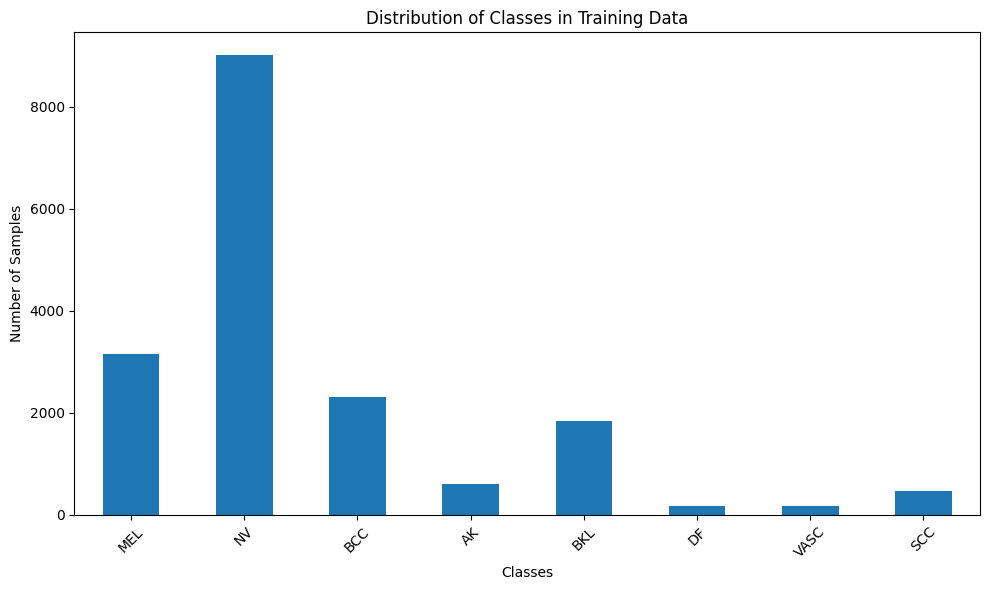

In [ ]:
import matplotlib.pyplot as plt

class_counts = train_data[['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']].sum()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Distribution of Classes in Training Data')
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Calculate and print the number of samples for each category in the training data. Then, calculate the class imbalance ratio.

- **Calculate Class Counts**: Use `Counter` to count the number of samples for each category.
- **Print Class Counts**: Print the number of samples for each class.
- **Class Imbalance Ratio**: Compute the imbalance ratio by dividing the count of the most common class by the count of the least common class.


In [ ]:
from collections import Counter

# Calculate the number of samples for each category
class_counts = Counter(train_data[['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC']].values.argmax(axis=1))

# Print the number of samples for each category
for class_index, count in class_counts.items():
    print(f"Class {class_index}: {count} samples")

# Calculate the class imbalance ratio
most_common_class_count = class_counts.most_common(1)[0][1]
least_common_class_count = class_counts.most_common()[-1][1]
imbalance_ratio = most_common_class_count / least_common_class_count
print(f"Imbalance Ratio: {imbalance_ratio:.2f}")


Class 1: 9007 samples
Class 2: 2318 samples
Class 5: 171 samples
Class 0: 3158 samples
Class 7: 462 samples
Class 4: 1835 samples
Class 3: 603 samples
Class 6: 177 samples
Imbalance Ratio: 52.67


# Image Preprocessing and Data Augmentation

Define functions to load and preprocess images, perform data augmentation, and balance the dataset.

- **Import Libraries**: Import necessary libraries `numpy`, `tensorflow`, and `preprocess_input` from `tensorflow.keras.applications.densenet`.
- **Preprocess Image**:
  - Load and decode JPEG images from file paths.
  - Resize images to 224x224 pixels.
  - Apply DenseNet-specific preprocessing.
- **Augment Image**:
  - Define several augmentation techniques: vertical flip, 180-degree rotation, contrast adjustment, random crop and resize, and random zoom.
  - Randomly apply one of these augmentations to each image using `tf.switch_case`.
- **Balance and Augment Data**:
  - Ensure a balanced dataset by either augmenting underrepresented classes or downsampling overrepresented classes.
  - Define minimum (`min_samples`) and maximum (`max_samples`) sample counts for each class.
  - Augment classes with fewer samples than `min_samples` to reach the desired count.
  - Downsample classes with more samples than `max_samples` to reduce their size.
  - Concatenate the balanced dataset and return it.


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.densenet import preprocess_input

# Define the image loading and preprocessing function
def preprocess_image(file_path):
    image = tf.io.read_file(file_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = preprocess_input(image)
    return image

# Define the data augmentation function
def augment_image(image):
    choice = tf.random.uniform([], 0, 5, dtype=tf.int32)
    def flip_vertical():
        return tf.image.flip_up_down(image)
    def rotate_180():
        return tf.image.rot90(image, k=2)
    def adjust_contrast():
        return tf.image.random_contrast(image, lower=0.8, upper=1.2)
    def random_crop_and_resize():
        cropped = tf.image.random_crop(image, [200, 200, 3])
        return tf.image.resize(cropped, [224, 224])
    def random_zoom():
        scale = tf.random.uniform([], 0.8, 1.2)
        new_size = tf.cast(224 * scale, tf.int32)
        zoomed = tf.image.resize(image, [new_size, new_size])
        return tf.image.resize_with_crop_or_pad(zoomed, 224, 224)
    image = tf.switch_case(choice, {
        0: flip_vertical,
        1: rotate_180,
        2: adjust_contrast,
        3: random_crop_and_resize,
        4: random_zoom
    })
    return image

def balance_and_augment_data(data, min_samples=2000, max_samples=5000):
    label_columns = data.columns[1:]
    class_counts = data[label_columns].sum()

    balanced_data = []

    for label, count in class_counts.items():
        X_class = data[data[label] == 1]
        if count < min_samples:
            n_samples = int(min(max_samples, max(min_samples, 2 * count)))
            n_augment = n_samples - int(count)
            augmented = X_class.sample(n_augment, replace=True)
            X_class = pd.concat([X_class, augmented])
        elif count > max_samples:
            X_class = X_class.sample(max_samples, replace=False)
        balanced_data.append(X_class)

    balanced_data = pd.concat(balanced_data, ignore_index=True)
    return balanced_data


# Preprocess and Augment Image Functions

Define functions to preprocess and augment images, and create a TensorFlow dataset.

- **Preprocess and Augment Image**:
  - Preprocess the image using the previously defined `preprocess_image` function.
  - Augment the image using the `augment_image` function.
  - Return the augmented image.

- **Create Dataset**:
  - Define the `_parse_function` to preprocess and optionally augment images based on training and augmentation flags.
  - Create a TensorFlow dataset from image file paths and labels.
  - Apply the `_parse_function` to each element in the dataset.
  - Cache the dataset for performance.
  - Shuffle and repeat the dataset if it's used for training.
  - Batch the dataset and prefetch for performance optimization.
  - Return the prepared dataset.


In [ ]:
def preprocess_and_augment_image(file_path):
    image = preprocess_image(file_path)
    return augment_image(image)

def create_dataset(data, labels, is_training=True, augment=False, batch_size=32, strategy=None):
    def _parse_function(filename, label):
        image = preprocess_image(filename)
        if is_training and augment:
            image = augment_image(image)
        return image, tf.cast(label, tf.float32)

    images = tf.constant(data.values)
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()
    if is_training:
        dataset = dataset.shuffle(buffer_size=len(images))
        dataset = dataset.repeat()
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset


# Define and Compile the DenseNet201 Model

Create a custom DenseNet201 model with additional layers and define a custom F1 Score metric.

- **Create DenseNet201 Model**:
  - Load the pre-trained DenseNet201 model without the top layer (`include_top=False`).
  - Freeze the pre-trained weights to prevent them from being updated during training.
  - Add a `GlobalAveragePooling2D` layer to reduce the dimensionality.
  - Add a `Dropout` layer to reduce overfitting.
  - Add a fully connected `Dense` layer with 1024 units and ReLU activation.
  - Add an output `Dense` layer with softmax activation for classification into `num_classes`.
  - Create and return the complete model.

- **Define Custom F1 Score Metric**:
  - Define a custom metric class `F1Score` that inherits from `tf.keras.metrics.Metric`.
  - Initialize with `Precision` and `Recall` metrics.
  - Implement `update_state` to update precision and recall with the true and predicted labels.
  - Implement `result` to compute the F1 score using the precision and recall values.
  - Implement `reset_state` to reset precision and recall states.

This setup allows the model to leverage pre-trained DenseNet201 features while adding custom layers to adapt to the specific classification task. The custom F1 Score metric provides a balanced measure of model performance.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC, Precision, Recall

# Define the model creation function
def create_densenet201_model(num_classes):
    # Load the DenseNet201 model and remove the top layer
    base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
    # Freeze the pre-trained weights
    base_model.trainable = False
    # Add custom layers
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)  # Add a dropout layer to prevent overfitting
    x = Dense(1024, activation='relu')(x)  # Add a fully connected layer
    predictions = Dense(num_classes, activation='softmax')(x)  # Output layer using softmax activation function
    # Create the complete model
    model = Model(inputs=base_model.input, outputs=predictions)
    return model

# Define F1 Score
@tf.keras.utils.register_keras_serializable()
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    @tf.function
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_labels = tf.argmax(y_pred, axis=-1)
        y_true_labels = tf.argmax(y_true, axis=-1)
        self.precision.update_state(y_true_labels, y_pred_labels, sample_weight)
        self.recall.update_state(y_true_labels, y_pred_labels, sample_weight)

    @tf.function
    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    @tf.function
    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

In [ ]:
# Set the batch size for each TPU core
PER_CORE_BATCH_SIZE = 32
# Calculate the total batch size
GLOBAL_BATCH_SIZE = PER_CORE_BATCH_SIZE * strategy.num_replicas_in_sync

train_labels = train_data.iloc[:, 1:]
val_labels = val_data.iloc[:, 1:]
test_labels = test_data.iloc[:, 1:]

balanced_train_data = balance_and_augment_data(train_data)
balanced_train_labels = balanced_train_data.iloc[:, 1:]

with strategy.scope():
    # Create the datasets
    original_train_dataset = create_dataset(train_data['image'], train_labels, is_training=True, augment=False, batch_size=GLOBAL_BATCH_SIZE)
    balanced_train_dataset = create_dataset(balanced_train_data['image'], balanced_train_labels, is_training=True, augment=True, batch_size=GLOBAL_BATCH_SIZE)
    val_dataset = create_dataset(val_data['image'], val_labels, is_training=False, batch_size=GLOBAL_BATCH_SIZE)
    test_dataset = create_dataset(test_data['image'], test_labels, is_training=False, batch_size=GLOBAL_BATCH_SIZE)

    # Distribute the datasets
    original_train_dist = strategy.experimental_distribute_dataset(original_train_dataset)
    balanced_train_dist = strategy.experimental_distribute_dataset(balanced_train_dataset)
    val_dist = strategy.experimental_distribute_dataset(val_dataset)

# Verify the datasets
print(f"Original training data size: {len(train_data)}")
print(f"Balanced training data size: {len(balanced_train_data)}")
print(f"Validation data size: {len(val_data)}")
print(f"Test data size: {len(test_data)}")
print(f"Global batch size: {GLOBAL_BATCH_SIZE}")
print(f"Number of replicas: {strategy.num_replicas_in_sync}")

Original training data size: 17731
Balanced training data size: 22146
Validation data size: 3800
Test data size: 3800
Global batch size: 256
Number of replicas: 8


# Prepare Datasets and Distribute for TPU Training

Set the batch size, balance the training data, create datasets, and distribute them across TPU cores for training.

- **Set Batch Sizes**:
  - Define the per-core batch size (`PER_CORE_BATCH_SIZE`).
  - Calculate the total global batch size (`GLOBAL_BATCH_SIZE`) by multiplying the per-core batch size by the number of replicas in sync.

- **Extract Labels**:
  - Extract labels from the training, validation, and test datasets.

- **Balance Training Data**:
  - Balance the training data to address class imbalances.
  - Extract labels from the balanced training data.

- **Create Datasets**:
  - Use `strategy.scope()` to ensure the operations are properly distributed across TPU cores.
  - Create datasets for the original and balanced training data, validation data, and test data.
  - Use the `create_dataset` function to preprocess and optionally augment the images.

- **Distribute Datasets**:
  - Distribute the datasets using `strategy.experimental_distribute_dataset` to ensure they are evenly distributed across TPU cores.

- **Verify Datasets**:
  - Print the sizes of the original training, balanced training, validation, and test datasets.
  - Print the global batch size and the number of TPU replicas in sync.

This setup ensures that the datasets are properly balanced, preprocessed, augmented, and distributed for efficient TPU training.


# Create, Compile, and Train the Model

Set up and train the DenseNet201 model using the defined TPU strategy.

- **Create the Model**:
  - Use the `strategy.scope()` to ensure the model creation and training steps are distributed across TPU cores.
  - Call `create_densenet201_model` to create the DenseNet201 model with 8 output classes.

- **Compile the Model**:
  - Compile the model with the Adam optimizer and categorical cross-entropy loss function.
  - Add accuracy, precision, recall, AUC, and the custom F1 score as metrics for evaluation.

- **Train the Model**:
  - Train the model using `model.fit` with the original training dataset and validation dataset.
  - Set the number of epochs to 50.
  - Calculate `steps_per_epoch` and `validation_steps` based on the lengths of the training and validation datasets divided by the global batch size.
  - Store the training history for further analysis.

This ensures the model is properly set up, compiled with the necessary metrics, and trained on the distributed dataset.


In [ ]:
with strategy.scope():
    # Create the model
    model = create_densenet201_model(num_classes=8)
    # Compile the model, adding the necessary metrics
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy',
                           Precision(name='precision'),
                           Recall(name='recall'),
                           AUC(name='auc'),
                           F1Score(name='f1_score')])

    history = model.fit(original_train_dist, validation_data=val_dist, epochs=50, steps_per_epoch=len(train_data)//GLOBAL_BATCH_SIZE, validation_steps=len(val_data)//GLOBAL_BATCH_SIZE)


Epoch 1/50
69/69 [==============================] - 333s 643ms/step - loss: 1.3597 - accuracy: 0.5721 - precision: 0.6724 - recall: 0.4634 - auc: 0.8795 - f1_score: 0.8729 - val_loss: 0.9807 - val_accuracy: 0.6730 - val_precision: 0.8478 - val_recall: 0.4601 - val_auc: 0.9351 - val_f1_score: 0.9077
Epoch 2/50
69/69 [==============================] - 24s 355ms/step - loss: 1.0055 - accuracy: 0.6352 - precision: 0.7460 - recall: 0.5175 - auc: 0.9271 - f1_score: 0.8977 - val_loss: 0.9421 - val_accuracy: 0.6657 - val_precision: 0.8197 - val_recall: 0.4794 - val_auc: 0.9396 - val_f1_score: 0.8818
Epoch 3/50
69/69 [==============================] - 17s 252ms/step - loss: 0.9681 - accuracy: 0.6495 - precision: 0.7576 - recall: 0.5327 - auc: 0.9324 - f1_score: 0.9002 - val_loss: 0.9420 - val_accuracy: 0.6663 - val_precision: 0.8310 - val_recall: 0.4774 - val_auc: 0.9406 - val_f1_score: 0.9063
Epoch 4/50
69/69 [==============================] - 17s 247ms/step - loss: 0.9407 - accuracy: 0.6530 -

# Plot Training Metrics

Visualize the changes in various metrics during the training process.

- **Import Matplotlib**:
  - Import the `matplotlib.pyplot` module for plotting.

- **Plot Accuracy**:
  - Plot training (`accuracy`) and validation accuracy (`val_accuracy`) over epochs.
  - Label the x-axis as 'Epoch' and y-axis as 'Accuracy'.
  - Add a legend to distinguish between training and validation accuracy.
  - Display the plot.

- **Plot Loss**:
  - Plot training (`loss`) and validation loss (`val_loss`) over epochs.
  - Label the x-axis as 'Epoch' and y-axis as 'Loss'.
  - Add a legend to distinguish between training and validation loss.
  - Display the plot.

- **Plot Precision**:
  - Plot training (`precision`) and validation precision (`val_precision`) over epochs.
  - Label the x-axis as 'Epoch' and y-axis as 'Precision'.
  - Add a legend to distinguish between training and validation precision.
  - Display the plot.

- **Plot Recall**:
  - Plot training (`recall`) and validation recall (`val_recall`) over epochs.
  - Label the x-axis as 'Epoch' and y-axis as 'Recall'.
  - Add a legend to distinguish between training and validation recall.
  - Display the plot.

- **Plot AUC**:
  - Plot training (`auc`) and validation AUC (`val_auc`) over epochs.
  - Label the x-axis as 'Epoch' and y-axis as 'AUC'.
  - Add a legend to distinguish between training and validation AUC.
  - Display the plot.

- **Plot F1 Score**:
  - Plot training (`f1_score`) and validation F1 score (`val_f1_score`) over epochs.
  - Label the x-axis as 'Epoch' and y-axis as 'F1 Score'.
  - Add a legend to distinguish between training and validation F1 score.
  - Display the plot.

These plots help to monitor the model's performance and identify any potential issues such as overfitting or underfitting during the training process.


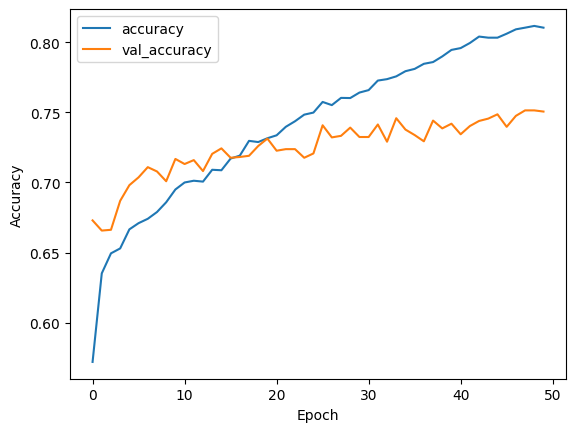

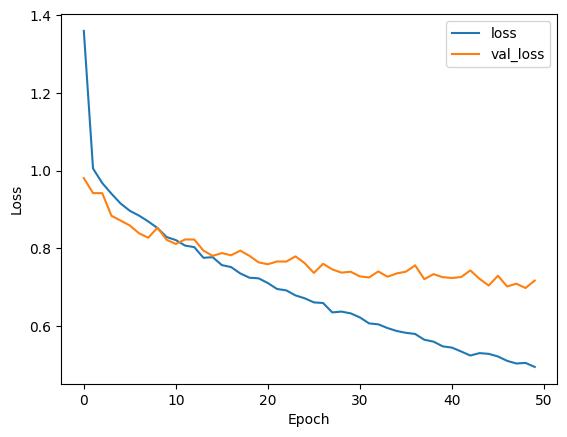

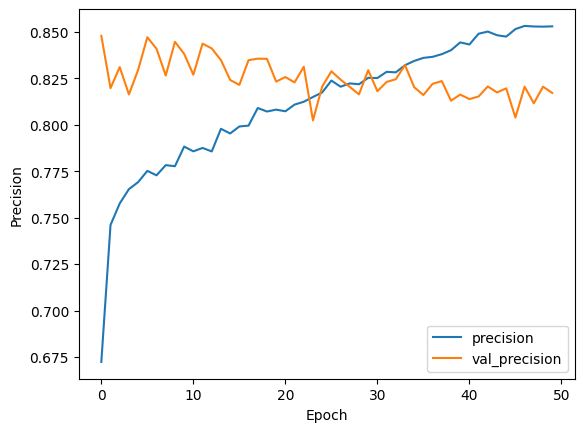

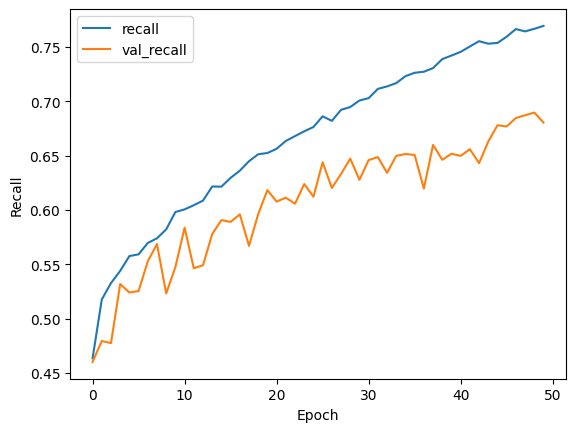

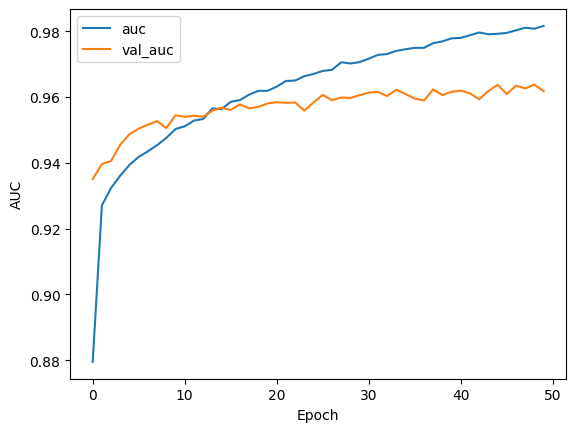

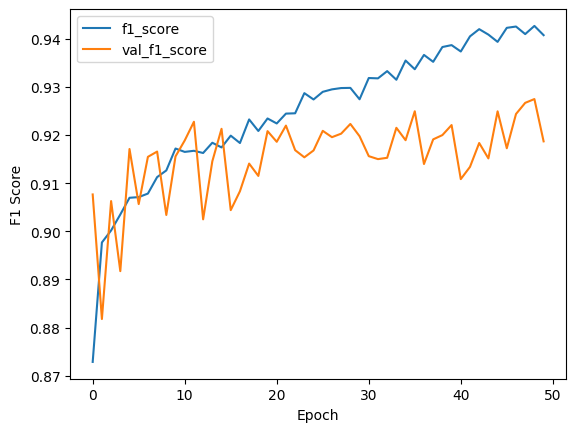

In [ ]:
# Plot the changes in metrics during training
import matplotlib.pyplot as plt

# Plot accuracy changes
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss changes
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Precision changes
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label='val_precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot Recall changes
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()

# Plot AUC changes
plt.plot(history.history['auc'], label='auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

# Plot F1 Score changes
plt.plot(history.history['f1_score'], label='f1_score')
plt.plot(history.history['val_f1_score'], label='val_f1_score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

# Evaluate Model Performance

Evaluate the model's performance on the test dataset using classification metrics and AUC-ROC scores.

- **Import Libraries**:
  - Import necessary libraries: `classification_report` and `roc_auc_score` from `sklearn.metrics`, `numpy`, `tensorflow`, and `LabelEncoder` from `sklearn.preprocessing`.

- **Label Encoding**:
  - Initialize a `LabelEncoder` and fit it on the training data's column names to encode the class labels.

- **Retrieve True Labels and Predictions**:
  - Convert true labels to one-hot encoding using `tf.keras.utils.to_categorical`.
  - Get model predictions for the test dataset.
  - Convert the predicted probabilities to class labels using `np.argmax`.
  - Convert the one-hot encoded true labels to class labels using `np.argmax`.

- **Calculate Classification Metrics**:
  - Use `classification_report` to calculate precision, recall, and F1 score for each class.
  - Print the classification report.

- **Calculate AUC-ROC Scores**:
  - Calculate the AUC-ROC score for each class using `roc_auc_score` with the one-vs-rest (`ovr`) strategy.
  - Print the AUC-ROC score for each class.

This evaluation provides detailed insights into the model's performance across different metrics and classes, helping to identify strengths and areas for improvement.


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(train_data.columns[1:])

# Retrieve true labels and model predictions from the test dataset
y_true_one_hot = tf.keras.utils.to_categorical(y_true, num_classes=8)
y_pred_prob = model.predict(test_dataset)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true = np.argmax(y_true_one_hot, axis=1)

# Calculate precision, recall, and F1 score for each class
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_, output_dict=True)
print(report)

# Calculate the AUC for each category
roc_auc = roc_auc_score(y_true_one_hot, y_pred_prob, multi_class='ovr', average=None)

for idx, class_name in enumerate(label_encoder.classes_):
    print(f"[{class_name}] AUC ROC: {roc_auc[idx]}")


14/14 [==============================] - 2s 108ms/step
{'AK': {'precision': 0.6152796725784447, 'recall': 0.6854103343465046, 'f1-score': 0.6484543493889288, 'support': 658.0}, 'BCC': {'precision': 0.8268330733229329, 'recall': 0.8952702702702703, 'f1-score': 0.8596918085969181, 'support': 1776.0}, 'BKL': {'precision': 0.7517899761336515, 'recall': 0.65625, 'f1-score': 0.7007786429365962, 'support': 480.0}, 'DF': {'precision': 0.55, 'recall': 0.32116788321167883, 'f1-score': 0.4055299539170507, 'support': 137.0}, 'MEL': {'precision': 0.6268115942028986, 'recall': 0.44473007712082263, 'f1-score': 0.5203007518796993, 'support': 389.0}, 'NV': {'precision': 0.4411764705882353, 'recall': 0.5, 'f1-score': 0.46875, 'support': 30.0}, 'SCC': {'precision': 0.7333333333333333, 'recall': 0.5945945945945946, 'f1-score': 0.6567164179104478, 'support': 37.0}, 'VASC': {'precision': 0.4157303370786517, 'recall': 0.4805194805194805, 'f1-score': 0.44578313253012053, 'support': 77.0}, 'accuracy': 0.738560

# Evaluate the Model on the Test Set

Evaluate the model's performance on the test set and print the resulting metrics.

- **Evaluate Model**:
  - Use `model.evaluate` to evaluate the model on the test dataset.
  - Retrieve the loss, accuracy, precision, recall, AUC, and F1 score from the evaluation.

- **Print Evaluation Metrics**:
  - Print the loss on the test set.
  - Print the accuracy on the test set.
  - Print the precision on the test set.
  - Print the recall on the test set.
  - Print the AUC on the test set.
  - Print the F1 score on the test set.

This provides a quick summary of the model's performance on unseen data, offering insights into its effectiveness and areas that may need further tuning.


In [ ]:
# Evaluate the model on the test set
loss, accuracy, precision, recall, auc, f1_score = model.evaluate(test_dataset)

print(f"Loss on test set: {loss}")
print(f"Accuracy on test set: {accuracy}")
print(f"Precision on test set: {precision}")
print(f"Recall on test set: {recall}")
print(f"AUC on test set: {auc}")
print(f"F1 Score on test set: {f1_score}")


14/14 [==============================] - 3s 114ms/step - loss: 0.7054 - accuracy: 0.7386 - precision: 0.8142 - recall: 0.6724 - auc: 0.9632 - f1_score: 0.9154
Loss on test set: 0.7053583860397339
Accuracy on test set: 0.7385602593421936
Precision on test set: 0.8141891956329346
Recall on test set: 0.6724330186843872
AUC on test set: 0.9631901383399963
F1 Score on test set: 0.9153539538383484


# Make Predictions and Evaluate the Model on the Test Set

Use the model to make predictions on the test dataset and evaluate its performance using various metrics.

- **Make Predictions**:
  - Use `model.predict` to get the predicted probabilities for the test dataset.
  - Convert the predicted probabilities to class labels using `np.argmax`.

- **Retrieve True Labels**:
  - Concatenate the true labels from the test dataset batches.
  - Convert the one-hot encoded true labels to integer labels using `np.argmax`.

- **Import Metrics**:
  - Import `classification_report`, `accuracy_score`, and `roc_auc_score` from `sklearn.metrics`.

- **Calculate Classification Metrics**:
  - Generate a classification report using `classification_report` to calculate accuracy, precision, recall, and F1 score for each class.
  - Print the classification report.

This provides a detailed evaluation of the model's performance, helping to assess its effectiveness across different metrics and classes.


In [ ]:
# Use the model to make predictions on the test set
y_pred_prob = model.predict(test_dataset)
y_pred = np.argmax(y_pred_prob, axis=1)

y_true_one_hot = np.concatenate([y for _, y in test_dataset], axis=0)
y_true = np.argmax(y_true_one_hot, axis=1)  # Convert one-hot encoding to integer labels

14/14 [==============================] - 2s 109ms/step


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

# Calculate accuracy, recall, and F1 score
report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
print(report)

              precision    recall  f1-score   support

          AK       0.62      0.69      0.65       658
         BCC       0.83      0.90      0.86      1776
         BKL       0.75      0.66      0.70       480
          DF       0.55      0.32      0.41       137
         MEL       0.63      0.44      0.52       389
          NV       0.44      0.50      0.47        30
         SCC       0.73      0.59      0.66        37
        VASC       0.42      0.48      0.45        77

    accuracy                           0.74      3584
   macro avg       0.62      0.57      0.59      3584
weighted avg       0.73      0.74      0.73      3584



# Plot Confusion Matrix

Visualize the confusion matrix to understand the performance of the model on the test dataset.

- **Import Libraries**:
  - Import `matplotlib.pyplot` for plotting.
  - Import `confusion_matrix` from `sklearn.metrics`.
  - Import `seaborn` for advanced visualization.

- **Calculate Confusion Matrix**:
  - Compute the confusion matrix using `confusion_matrix` with the true and predicted labels.

- **Plot Confusion Matrix**:
  - Create a heatmap of the confusion matrix using `sns.heatmap`.
  - Set the figure size to (10, 7).
  - Annotate the heatmap with the confusion matrix values.
  - Use the 'Blues' colormap for better visualization.
  - Set the x-tick and y-tick labels to the class names using `label_encoder.classes_`.
  - Label the x-axis as 'Predicted' and the y-axis as 'True'.
  - Display the plot using `plt.show()`.

This confusion matrix provides a detailed view of the model's performance, highlighting areas where the model performs well and where it may need improvement.


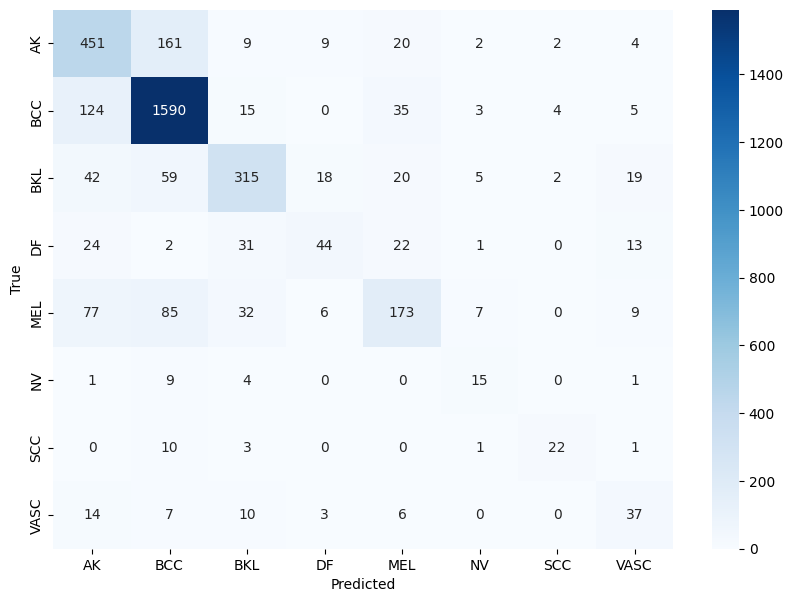

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Plotting the confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Plot ROC Curve for Each Category

Visualize the ROC curve to evaluate the performance of the model in distinguishing between classes.

- **Import Libraries**:
  - Import `roc_curve` and `auc` from `sklearn.metrics`.

- **Compute ROC Curve and AUC**:
  - Calculate the false positive rate (`fpr`) and true positive rate (`tpr`) using `roc_curve`.
  - Compute the area under the ROC curve (`roc_auc`) using `auc`.

- **Plot ROC Curve**:
  - Create a new figure for the ROC curve plot.
  - Set line width (`lw`) to 2 for better visibility.
  - Plot the ROC curve using `plt.plot`, labeling it with the AUC value.
  - Plot the diagonal line representing random performance using `plt.plot`.
  - Set the x-axis limit from 0.0 to 1.0 and y-axis limit from 0.0 to 1.05.
  - Label the x-axis as 'False Positive Rate' and the y-axis as 'True Positive Rate'.
  - Set the title to 'Receiver Operating Characteristic'.
  - Add a legend to the lower right corner.
  - Display the plot using `plt.show()`.

This ROC curve helps to visualize the trade-off between sensitivity and specificity for the model, providing insight into its diagnostic ability.


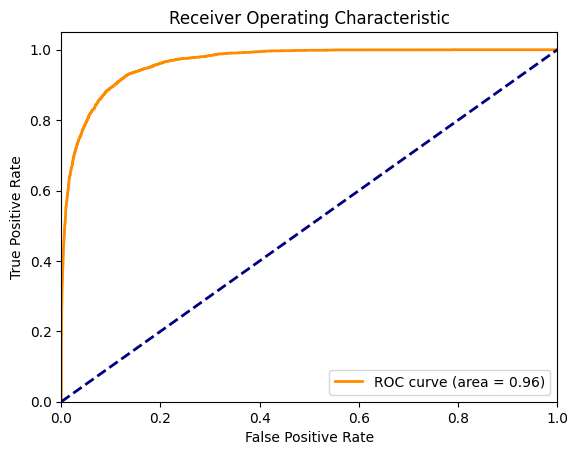

In [ ]:
# Plotting the ROC Curve (for each category)
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true_one_hot.ravel(), y_pred_prob.ravel())
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# Training with Augmented Dataset

Train the DenseNet201 model using the augmented and balanced training dataset.

In [ ]:
with strategy.scope():
    model = create_densenet201_model(num_classes=8)
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy', Precision(name='precision'), Recall(name='recall'), AUC(name='auc'), F1Score(name='f1_score')])
    history = model.fit(balanced_train_dist,
                    validation_data=val_dist,
                    epochs=50,
                    steps_per_epoch=len(balanced_train_data) // GLOBAL_BATCH_SIZE,
                    validation_steps=len(val_data) // GLOBAL_BATCH_SIZE)


Epoch 1/50
86/86 [==============================] - 119s 437ms/step - loss: 1.5656 - accuracy: 0.4401 - precision: 0.6062 - recall: 0.2499 - auc: 0.8196 - f1_score: 0.9029 - val_loss: 1.1301 - val_accuracy: 0.5865 - val_precision: 0.7803 - val_recall: 0.3597 - val_auc: 0.9106 - val_f1_score: 0.8955
Epoch 2/50
86/86 [==============================] - 20s 233ms/step - loss: 1.2723 - accuracy: 0.5298 - precision: 0.6941 - recall: 0.3420 - auc: 0.8811 - f1_score: 0.9152 - val_loss: 1.0402 - val_accuracy: 0.6203 - val_precision: 0.8283 - val_recall: 0.4051 - val_auc: 0.9262 - val_f1_score: 0.9031
Epoch 3/50
86/86 [==============================] - 13s 146ms/step - loss: 1.1889 - accuracy: 0.5598 - precision: 0.7178 - recall: 0.3782 - auc: 0.8971 - f1_score: 0.9180 - val_loss: 1.0433 - val_accuracy: 0.6155 - val_precision: 0.8074 - val_recall: 0.4104 - val_auc: 0.9233 - val_f1_score: 0.9109
Epoch 4/50
86/86 [==============================] - 13s 147ms/step - loss: 1.1357 - accuracy: 0.5755 -

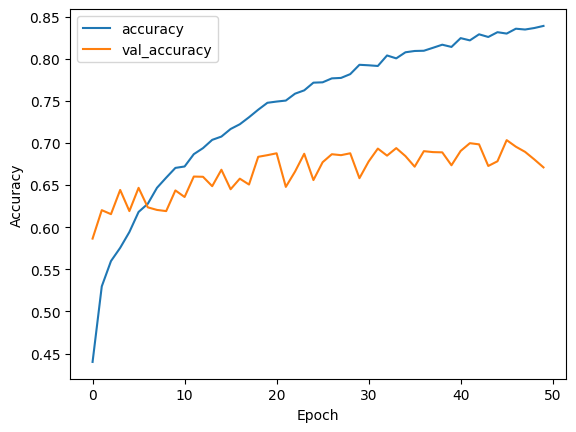

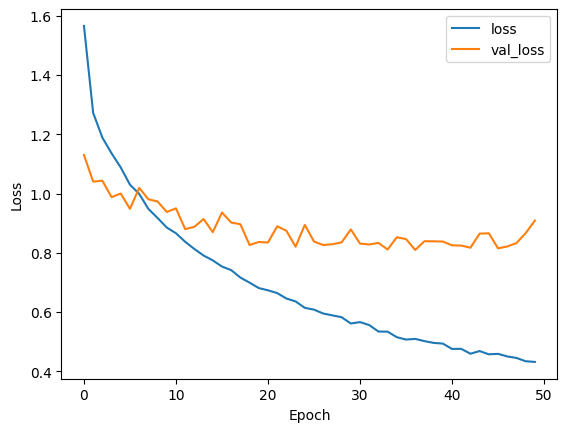

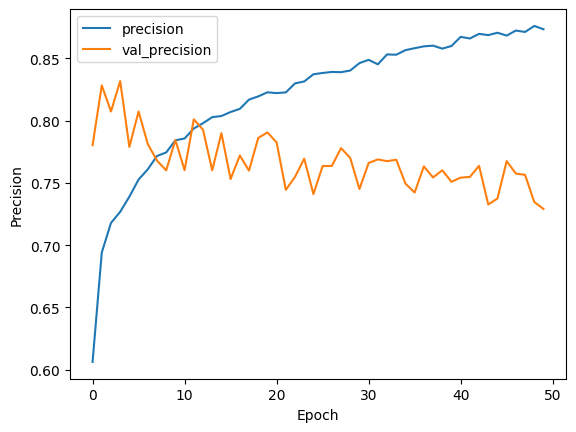

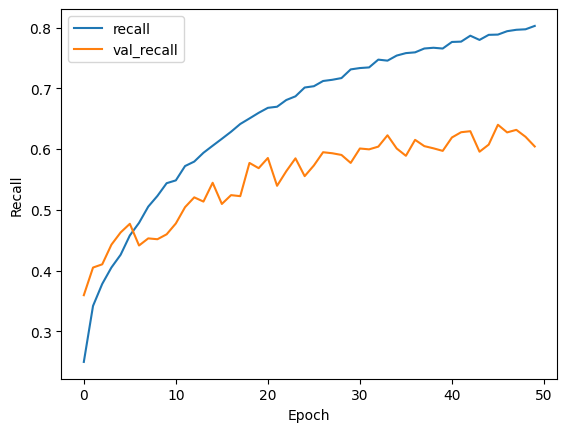

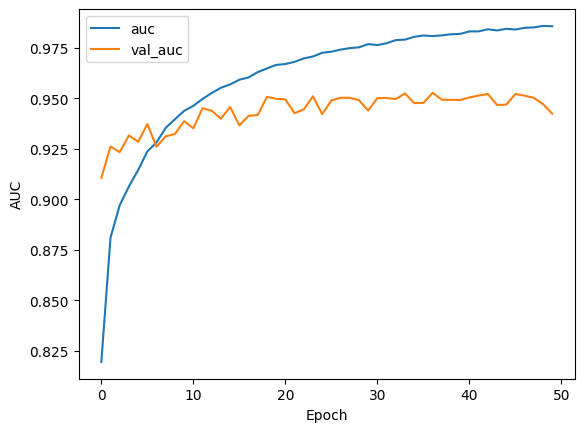

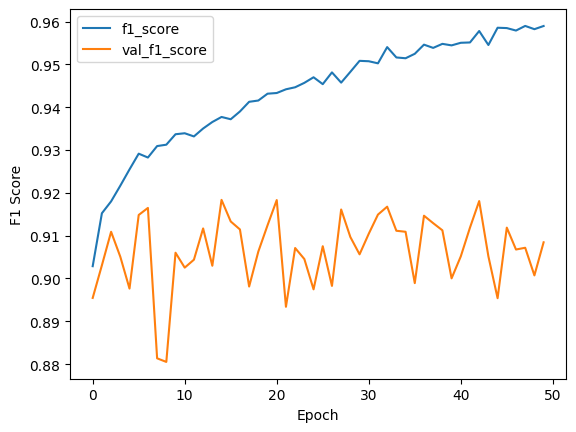

In [ ]:
# Plot the changes in metrics during training
import matplotlib.pyplot as plt

# Plot accuracy changes
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss changes
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Precision changes
plt.plot(history.history['precision'], label='precision')
plt.plot(history.history['val_precision'], label='val_precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()
plt.show()

# Plot Recall changes
plt.plot(history.history['recall'], label='recall')
plt.plot(history.history['val_recall'], label='val_recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()
plt.show()

# Plot AUC changes
plt.plot(history.history['auc'], label='auc')
plt.plot(history.history['val_auc'], label='val_auc')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()
plt.show()

# Plot F1 Score changes
plt.plot(history.history['f1_score'], label='f1_score')
plt.plot(history.history['val_f1_score'], label='val_f1_score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
label_encoder.fit(train_data.columns[1:])

# Calculate classification report and AUC ROC
y_true = np.concatenate([y for x, y in test_dataset], axis=0)
y_pred_prob = model.predict(test_dataset)
y_pred = np.argmax(y_pred_prob, axis=1)
y_true_labels = np.argmax(y_true, axis=1)  # Convert from one-hot encoding to integer labels

# Calculate precision, recall, and F1 score for each class
report = classification_report(y_true_labels, y_pred, target_names=label_encoder.classes_, output_dict=True)
print(report)

# Calculate AUC ROC for each class
roc_auc = roc_auc_score(y_true, y_pred_prob, multi_class='ovr', average=None)
for idx, class_name in enumerate(label_encoder.classes_):
    print(f"{class_name} AUC ROC: {roc_auc[idx]}")

14/14 [==============================] - 21s 109ms/step
{'AK': {'precision': 0.6115444617784711, 'recall': 0.5957446808510638, 'f1-score': 0.6035411855273286, 'support': 658.0}, 'BCC': {'precision': 0.8907672301690507, 'recall': 0.7713963963963963, 'f1-score': 0.8267954133977067, 'support': 1776.0}, 'BKL': {'precision': 0.6932084309133489, 'recall': 0.6166666666666667, 'f1-score': 0.6527012127894157, 'support': 480.0}, 'DF': {'precision': 0.41237113402061853, 'recall': 0.583941605839416, 'f1-score': 0.4833836858006042, 'support': 137.0}, 'MEL': {'precision': 0.5100222717149221, 'recall': 0.5886889460154242, 'f1-score': 0.5465393794749404, 'support': 389.0}, 'NV': {'precision': 0.4, 'recall': 0.6, 'f1-score': 0.48, 'support': 30.0}, 'SCC': {'precision': 0.5555555555555556, 'recall': 0.8108108108108109, 'f1-score': 0.6593406593406594, 'support': 37.0}, 'VASC': {'precision': 0.25, 'recall': 0.7662337662337663, 'f1-score': 0.37699680511182104, 'support': 77.0}, 'accuracy': 0.69029017857142

In [ ]:
loss, accuracy, precision, recall, auc, f1_score = model.evaluate(test_dataset)

print(f"Loss on test set: {loss}")
print(f"Accuracy on test set: {accuracy}")
print(f"Precision on test set: {precision}")
print(f"Recall on test set: {recall}")
print(f"AUC on test set: {auc}")
print(f"F1 Score on test set: {f1_score}")

14/14 [==============================] - 3s 118ms/step - loss: 0.8367 - accuracy: 0.6903 - precision: 0.7491 - recall: 0.6197 - auc: 0.9505 - f1_score: 0.9123
Loss on test set: 0.8366888165473938
Accuracy on test set: 0.6902901530265808
Precision on test set: 0.7490724921226501
Recall on test set: 0.6196986436843872
AUC on test set: 0.9504571557044983
F1 Score on test set: 0.912250816822052


In [ ]:
y_pred_prob = model.predict(test_dataset)
y_pred = np.argmax(y_pred_prob, axis=1)

y_true_one_hot = np.concatenate([y for _, y in test_dataset], axis=0)
y_true = np.argmax(y_true_one_hot, axis=1)


14/14 [==============================] - 2s 110ms/step


In [ ]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

report = classification_report(y_true, y_pred, target_names=label_encoder.classes_)
print(report)


              precision    recall  f1-score   support

          AK       0.61      0.60      0.60       658
         BCC       0.89      0.77      0.83      1776
         BKL       0.69      0.62      0.65       480
          DF       0.41      0.58      0.48       137
         MEL       0.51      0.59      0.55       389
          NV       0.40      0.60      0.48        30
         SCC       0.56      0.81      0.66        37
        VASC       0.25      0.77      0.38        77

    accuracy                           0.69      3584
   macro avg       0.54      0.67      0.58      3584
weighted avg       0.73      0.69      0.70      3584



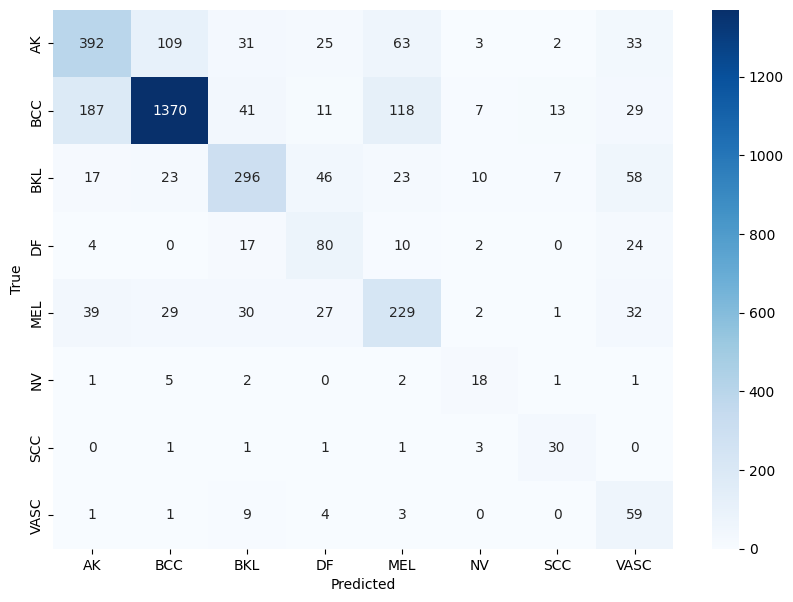

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

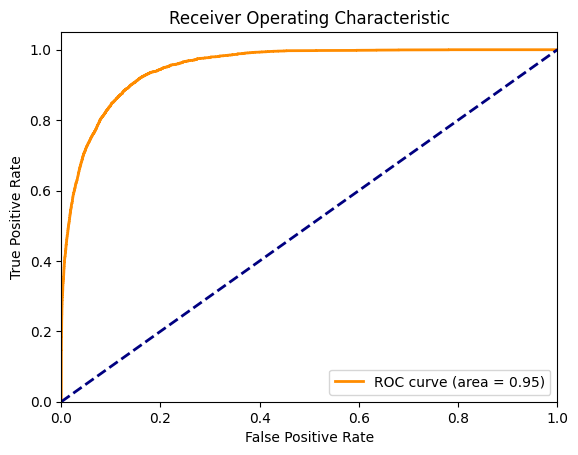

In [ ]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true_one_hot.ravel(), y_pred_prob.ravel())
roc_auc = auc(fpr, tpr)
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


# DenseNet201 + Cubic SVM

Create a TensorFlow dataset for SVM training, including optional data augmentation and caching.

- **Define Dataset Creation Function**:
  - The function `create_dataset_svm` creates a dataset from the provided data and labels.
  - Parameters:
    - `data`: DataFrame containing image file paths.
    - `labels`: Corresponding labels for the images.
    - `is_training`: Boolean to indicate if the dataset is for training (default is True).
    - `augment`: Boolean to indicate if data augmentation should be applied (default is False).
    - `batch_size`: Size of batches for training (default is 32).
    - `strategy`: Distribution strategy (default is None).

- **Image Parsing Function**:
  - The nested function `_parse_function` loads and preprocesses images from file paths.
  - If `is_training` and `augment` are True, it applies data augmentation.

- **Create TensorFlow Dataset**:
  - Convert the image file paths to a TensorFlow constant.
  - Create a dataset from tensor slices of image file paths and labels.
  - Map the `_parse_function` to each element in the dataset, enabling parallel calls with `tf.data.AUTOTUNE`.

- **Optimize Dataset**:
  - Cache the dataset for performance improvement.
  - If `is_training`, shuffle the dataset with a buffer size equal to the number of images.
  - Batch the dataset, dropping the remainder to ensure all batches are the same size.
  - Prefetch data to optimize input pipeline performance with `tf.data.AUTOTUNE`.

- **Return Dataset**:
  - Return the prepared dataset for SVM training.



In [ ]:
def create_dataset_svm(data, labels, is_training=True, augment=False, batch_size=32, strategy=None):
    def _parse_function(filename, label):
        image = preprocess_image(filename)
        if is_training and augment:
            image = augment_image(image)
        return image, tf.cast(label, tf.float32)

    images = tf.constant(data.values)
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    dataset = dataset.map(_parse_function, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.cache()
    if is_training:
        dataset = dataset.shuffle(buffer_size=len(images))
    dataset = dataset.batch(batch_size, drop_remainder=True)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    return dataset

# Feature Extraction using DenseNet201

Extract features from images using a pre-trained DenseNet201 model for use in SVM training.

## Define Feature Extraction Function

- **Import Libraries**: Import necessary libraries `tensorflow`, `DenseNet201` from `tensorflow.keras.applications`, `Model` from `tensorflow.keras.models`, and `numpy`.
- **Define `extract_features` Function**:
  - The function takes a model and a dataset as inputs.
  - It initializes empty lists for features and labels.
  - Iterates over the dataset, extracting features using the model's `predict` method.
  - Appends the extracted features and labels to their respective lists.
  - Returns the features and labels as numpy arrays using `np.vstack` and `np.concatenate`.

## Initialize DenseNet201 Model

- **Initialize DenseNet201**:
  - Load the DenseNet201 model pre-trained on ImageNet without the top layer (`include_top=False`).
  - Use average pooling (`pooling='avg'`) to aggregate features from the convolutional layers.
  - Set the input shape to (224, 224, 3).

- **Create Feature Extractor**:
  - Create a new model (`feature_extractor`) with the same inputs as `base_model` but outputs the processed features from the base model.

This setup allows you to extract features from images using DenseNet201, which can then be used as input for an SVM or other machine learning models.


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.models import Model
import numpy as np

def extract_features(model, dataset):
    features = []
    labels = []

    for images, lbls in dataset:
        feature_batch = model.predict(images)
        features.append(feature_batch)
        labels.append(lbls)

    return np.vstack(features), np.concatenate(labels)

with strategy.scope():
    base_model = DenseNet201(weights='imagenet', include_top=False, pooling='avg', input_shape=(224, 224, 3))
    feature_extractor = tf.keras.Model(inputs=base_model.input, outputs=base_model.output)


# Extract Features for SVM Training

Create datasets for SVM training, and use a pre-trained DenseNet201 model to extract features.

## Create Datasets for SVM Training

- **Create Original Training Dataset**:
  - Use `create_dataset_svm` to create a dataset from the original training data without augmentation.
- **Create Balanced Training Dataset**:
  - Use `create_dataset_svm` to create a dataset from the balanced training data with augmentation.

## Extract Features Using DenseNet201

- **Scope for Distribution Strategy**:
  - Use `strategy.scope()` to ensure the feature extraction is distributed across TPU cores if applicable.
  
- **Extract Features and Labels**:
  - Extract features and labels from the original training dataset using `extract_features`.
  - Extract features and labels from the balanced training dataset using `extract_features`.
  - Extract features and labels from the test dataset using `extract_features`.

- **Store Results**:
  - Store the extracted features and labels from each dataset for further processing with SVM or other machine learning models.

This process prepares the datasets and extracts the necessary features using a pre-trained DenseNet201 model, making them ready for SVM training.

In [ ]:
original_train_dataset = create_dataset_svm(train_data['image'], train_labels, is_training=True, augment=False, batch_size=GLOBAL_BATCH_SIZE)
balanced_train_dataset = create_dataset_svm(balanced_train_data['image'], balanced_train_labels, is_training=True, augment=True, batch_size=GLOBAL_BATCH_SIZE)

with strategy.scope():
    original_train_features, original_train_labels = extract_features(feature_extractor, original_train_dataset)
    balanced_train_features, balanced_train_labels = extract_features(feature_extractor, balanced_train_dataset)
    test_features, test_labels = extract_features(feature_extractor, test_dataset)

8/8 [==============================] - 1s 40ms/step


# Train SVM Models on Extracted Features

Train SVM models using features extracted from the DenseNet201 model on both the original and balanced training datasets.

## Import Libraries and Create SVM Models

- **Import Libraries**:
  - Import the `svm` module from `sklearn`.
  - Import `StandardScaler` from `sklearn.preprocessing`.
  - Import `make_pipeline` from `sklearn.pipeline`.

- **Convert Labels**:
  - Convert the one-hot encoded labels to integer labels using `np.argmax` for both the original and balanced training labels.

- **Create SVM Model for Original Training Data**:
  - Create an SVM model pipeline (`svm_model_original`) that includes standard scaling and a polynomial kernel SVM (`SVC`).
  - Fit the SVM model on the extracted features and integer labels from the original training data.

- **Create SVM Model for Balanced Training Data**:
  - Create a similar SVM model pipeline (`svm_model_balanced`) for the balanced training data.
  - Fit the SVM model on the extracted features and integer labels from the balanced training data.

This setup allows for training SVM models on features extracted from both the original and balanced datasets, enabling comparison of their performance on downstream tasks.

In [ ]:
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Conversion of Labels: From One-Hot Encoding to Integer Labels
original_train_labels = np.argmax(original_train_labels, axis=1)
balanced_train_labels = np.argmax(balanced_train_labels, axis=1)

svm_model_original = make_pipeline(StandardScaler(), svm.SVC(kernel='poly', degree=3, C=1.0, probability=True))
svm_model_original.fit(original_train_features, original_train_labels)

svm_model_balanced = make_pipeline(StandardScaler(), svm.SVC(kernel='poly', degree=3, C=1.0, probability=True))
svm_model_balanced.fit(balanced_train_features, balanced_train_labels)


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('svc', SVC(kernel='poly', probability=True))])

# Evaluate SVM Models on Test Set

Evaluate the performance of SVM models trained on original and balanced datasets using the test set.

## Convert Labels

Convert one-hot encoded labels to integer labels for evaluation.

- **Convert Labels**: Convert one-hot encoded labels to integer labels using `np.argmax`.
- **LabelEncoder**: Initialize and fit a `LabelEncoder` using the integer labels from the training set.

## Define Model Evaluation Function

Define a function to evaluate the model's performance using various metrics.

- **Predictions**: Use the model to predict labels (`y_pred`) and probabilities (`y_pred_prob`) for the test features.
- **Accuracy**: Calculate and print the overall accuracy using `accuracy_score`.
- **Classification Report**: Generate and print a detailed classification report using `classification_report`.
- **AUC Score**: Calculate and print the AUC ROC scores for each class using `roc_auc_score`.

## Evaluate Models

Evaluate both the original and balanced SVM models on the test set.

- **Evaluate Original SVM Model**: Evaluate the SVM model trained on the original training set.
- **Evaluate Balanced SVM Model**: Evaluate the SVM model trained on the balanced training set.

This process provides a comprehensive evaluation of the SVM models, allowing you to compare their performance on various metrics and determine the impact of data balancing.


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf

# Assume train_labels and test_labels are initially in one-hot encoding format
train_labels_integer = np.argmax(train_labels, axis=1)
test_labels_integer = np.argmax(test_labels, axis=1)

# Using LabelEncoder
label_encoder = LabelEncoder()
# Fit the LabelEncoder using train_labels_integer
label_encoder.fit(train_labels_integer)

def evaluate_model(model, test_features, test_labels_integer, label_encoder):
    y_pred = model.predict(test_features)  # Predicted labels
    y_pred_prob = model.predict_proba(test_features)  # Predicted probabilities

    # Calculate overall accuracy
    accuracy = accuracy_score(test_labels_integer, y_pred)
    print(f"Accuracy: {accuracy}")

    # Ensure class names are strings
    target_names = [str(cls) for cls in label_encoder.classes_]

    # Generate classification report
    report = classification_report(test_labels_integer, y_pred, target_names=target_names)
    print(report)

    # Calculate AUC, ensuring test_labels is converted to one-hot encoding
    test_labels_one_hot = tf.keras.utils.to_categorical(test_labels_integer, num_classes=len(label_encoder.classes_))
    auc = roc_auc_score(test_labels_one_hot, y_pred_prob, multi_class='ovr', average=None)

    if isinstance(auc, np.ndarray):
        for idx, class_name in enumerate(target_names):
            print(f"{class_name} AUC ROC: {auc[idx]}")
    else:
        print("AUC ROC: ", auc)

    return report, auc

# Evaluate the model using integer labels
print("Original Training Set Model Evaluation")
report_original, auc_original = evaluate_model(svm_model_original, test_features, test_labels_integer, label_encoder)

print("Balanced Training Set Model Evaluation")
report_balanced, auc_balanced = evaluate_model(svm_model_balanced, test_features, test_labels_integer, label_encoder)

Original Training Set Model Evaluation
Accuracy: 0.7427455357142857
              precision    recall  f1-score   support

           0       0.73      0.55      0.62       658
           1       0.77      0.95      0.85      1776
           2       0.67      0.77      0.72       480
           3       0.71      0.31      0.43       137
           4       0.70      0.44      0.54       389
           5       1.00      0.07      0.12        30
           6       1.00      0.27      0.43        37
           7       0.91      0.26      0.40        77

    accuracy                           0.74      3584
   macro avg       0.81      0.45      0.51      3584
weighted avg       0.74      0.74      0.72      3584

0 AUC ROC: 0.9106896143370308
1 AUC ROC: 0.9405681954077971
2 AUC ROC: 0.961659015249141
3 AUC ROC: 0.9393696835712425
4 AUC ROC: 0.9162774418576584
5 AUC ROC: 0.9441286812980679
6 AUC ROC: 0.9890124124688545
7 AUC ROC: 0.9635682253304152
Balanced Training Set Model Evaluation
Acc